# Final Assignment 
# Machine Learning for Robotics (RO47002) 2020/2021

Group Number:

Student 1 (name + student number):

Student 2 (name + student number):

---

*Note: Please remove this cell for the submission.*

## Task Description
In this final assignment, we revisit our robot from Practicum 2, which was able to pick up a pen after you trained it to recognize parts of the pen in its camera images. Now we want to teach the robot to be able to clean up a table after a meal. In particular, it needs to be able to pick up cutlery (forks, knives, spoons).  For that the robot needs to determine where the cutlery is located and where the handle is. The robot has a basic down-facing camera that it can place on top of the desk to inspect an area of interest. Your task is to design the machine learning method for this perception problem. To simplify the problem, we'll only consider a single type of cutlery (your choice of fork, spoon, or knife) and a single object visible in each camera picture.

## Deliverables
The deadline is Sunday October 25th, 23:59. Late submission is –1 grade point per day.

The main deliverable is a Jupyter Notebook, integrating the report (markdown cells) and the code. Submission is again in the form of a single ZIP file that includes all files required to run the notebook and reproduce the results (collected images, annotation data, loadable parameters, auxiliary scripts, etc.). The notebook needs to be able to run within 10 minutes on a high-end PC, performing all steps (also including the hyperparameter optimization and training).  Unlike previous lab assignments, there are no autograded cells or asserts, but we will grade the notebook manually. Therefore, you are free to add cells as you see fit, as long as the required sections are still present in the notebook.

## Grading Criteria
Below you will find an outline of the sections that the notebook needs to contain and what we expect for each part. More specific requirements are listed there as well. The indicated number of points, out of a total of 100, should give you a rough indication on how much effort to put into each part.

In general, we will not focus as much on the performance of the method you design, but rather the _level of understanding and argumentation about your design choices_. So, we are not only interested in WHAT you did, but will put a strong emphasis on your reasoning about the WHY. Try to synthesize rather than describing what you did step by step.

### Quality of the Report (20 points)
- Structure & Readability
 - Logical flow
 - Connection between parts
- English
 - Do not use short forms, like "isn't", "wouldn't".
 - Do not use colloquial style, like "a couple of".
 - Spell check and proofread your report.
- Level of detail
 - Strive for elegant, concise text - longer reports do not necessarily yield higher grades.
 - There is no need to re-explain theory. Assume that the target audience of the report has followed the course.
- Figures & Tables
 - Choose figures/plots/tables carefully. Only include those that add to the story of the report. Do not put the burden on the reviewer to figure out which results you basing your conclusions on, but specifically refer (parts of) the specific table/plot/figure when needed.
 - When comparing two or more signals display them in one plot. Explain the colors / line types. The scale of the plots must be carefully chosen in order to clearly convey the information intended. Label properly the axes in graphs (variables and units).
- Citations
 - If you use images, theory and methods beyond what was covered in the course, etc., always reference sources.


---

*Note: Please do not include the requirements in the submission.*

# Structure (inspired by the Machine Learning Project Checklist)

## Frame the Problem and Look at the Big Picture (10 points)
- How do you frame the learning problem? Please treat the main learning problem as a supervised learning problem. But can you best express it as a classification problem, a regression problem, an image segmentation problem, etc.? Note that there is not one best answer to this question, and the task could be addressed in different ways. We want to know your motivation for your selected approach.
- What are the runtime constraints, especially for predictions? How fast does the robot need to be able to process an image? What kind of platform do you assume (e.g., Arduino, Laptop, etc.)?
- How should performance be measured? What is the minimum performance required? What are the objectives? What kind of loss function is appropriate?
- What are promising algorithms?


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import os, glob

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import ipywidgets
from IPython.display import display

from collections import OrderedDict

import scipy
import skimage
import skimage.transform
import skimage.util

## Get the Data (15 points)
- Collect your own dataset, i.e., take pictures of your chosen type of cutlery on a table. What was your protocol? How many pictures do you need? What kind of variations did you try to capture? What kind of potential variations are you trying to avoid to capture?
- Annotate the data. Explain which options you considered and what you did in the end. If it is a custom annotation tool, include it in the submission, if you used an external tool, a link is sufficient
- Sample a test set
- *Note:* In contrast to Practicum 2, it is sufficient to just collect a single dataset and perform the training/testing split on that.

We are using knife images for training out dataset. Different kind of knives are selected with the different background. 
Annotation tool used was the one providd with Practicum 2.
Since we are not using a dataset which is dynamic we do not need compute the hash of each instances identifier.

To avoid the data snopping error we will split the dataset with the random seed constant so that the classifier is not trained on the test data set at all. We will keep the 20% of the dataset for the test purpose and the selection of the dataset will be random after shuffiling. To get the same shuffle and the same split of the data we will keep the random state of the test_train_split function.

Finding and Loading the Image print the image to check if the database is correct.

In [3]:
import glob
#image check funtion
def list_images(image_dir, filename_expression='*.JPG'):
    filenames = glob.glob(os.path.join(image_dir, filename_expression))
    filenames = sorted(filenames) # important for cross-platform compatiblity
    print(f'Found {len(filenames)} image files in the directory "{image_dir}"')
    return filenames

#making the list of the filenames
IMAGE_DIR = 'knife_database/RAW'
filenames = list_images(IMAGE_DIR)
N = len(filenames)

#loading the list of the images in a single variable
Is = [plt.imread(filename) for filename in filenames]
print('loaded %d images' % len(Is))
print("The shape of the ",np.shape(Is))

#using picle module to import the annotations of the image
import pickle

annots = None # store your results in the variable `annots`
annot_filename = os.path.join(IMAGE_DIR, 'annots.npy')

annot_exists = os.path.isfile(annot_filename)
print(f'Looking for annotations file "{annot_filename}":', 'found' if annot_exists else 'NOT found')

if annot_exists:
    print('Loading annotations')
    annots = pickle.load(open(annot_filename, 'rb'))
else:
    print('Initializing empty annotations array')
    annots = np.zeros((N,4)) 
    
#asserting the shape and the type of annots array
assert(type(annots) == np.ndarray)
assert(annots.shape == (35, 4))

Found 35 image files in the directory "knife_database/RAW"
loaded 35 images
The shape of the  (35, 768, 1024, 3)
Looking for annotations file "knife_database/RAW/annots.npy": found
Loading annotations


## Explore the Data (5 points)
- Visualize the data
- Study its properties


We can visualize the annotaion of the data on the image of the knife.
Creat a copy fo the traing set to play with it
Since are annotaion exist for all the images therefore we do not have to fill the gaps in the data


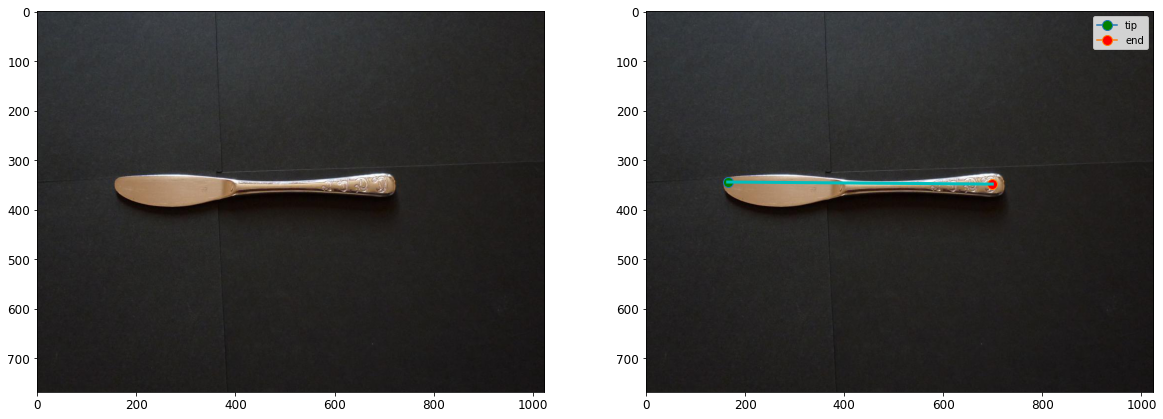

FOR THE SINGLE IMAGE
The height of the image is 768
The width of the image is 1024
The number of channel of the image is 3
The datatype of the single image is = uint8 

FOR THE GROUP OF DATA
The shape of the image array is  (35, 768, 1024, 3)
The dtype of the image array is = uint8 

FOR THE ANNOTATION MATRIX
The shape of the annotation matrix is (35, 4)
The datatype of the annotation matrix is = float64


In [4]:
#calculating the width and the height of the image
import numpy as np 

def show_annotation(I, p1, p2):
    plt.figure(figsize=(20,24))
    plt.subplot(1,2,1)
    plt.imshow(I)
    plt.subplot(1,2,2)
    plt.imshow(I)
    x = np.array([p1[0],p2[0]])
    y = np.array([p1[1],p2[1]])
    #2. plotting the green and the red circle
    plt.plot(p1[0],p1[1], marker="o", markersize=10, markerfacecolor="g", label="tip" )
    plt.plot(p2[0],p2[1], marker="o", markersize=10, markerfacecolor="r", label="end" )
    plt.plot(x,y, linewidth=3, color="c" )
    plt.legend(loc='upper right')
    
    plt.show()

#Enter the index of the image to be displayed
img_idx = 3
I = Is[img_idx]
p1 = annots[img_idx,:2].copy() # copty of point 1 of the pen
p2 = annots[img_idx,2:].copy() #copy of point 2 of the pen

#calling the show_annotation function to show the orignal imge and the annotation in the image

show_annotation(I, p1, p2)

#Exploring the data of the single image
print("FOR THE SINGLE IMAGE")
print("The height of the image is",np.shape(I)[0])
print("The width of the image is",np.shape(I)[1])
print("The number of channel of the image is",np.shape(I)[2])
print("The datatype of the single image is =",I.dtype,"\n")

print("FOR THE GROUP OF DATA")
print("The shape of the image array is ",np.shape(Is))
print("The dtype of the image array is =",np.asarray(Is).dtype,"\n")

print("FOR THE ANNOTATION MATRIX")
print("The shape of the annotation matrix is",np.shape(annots))
print("The datatype of the annotation matrix is =",annots.dtype)


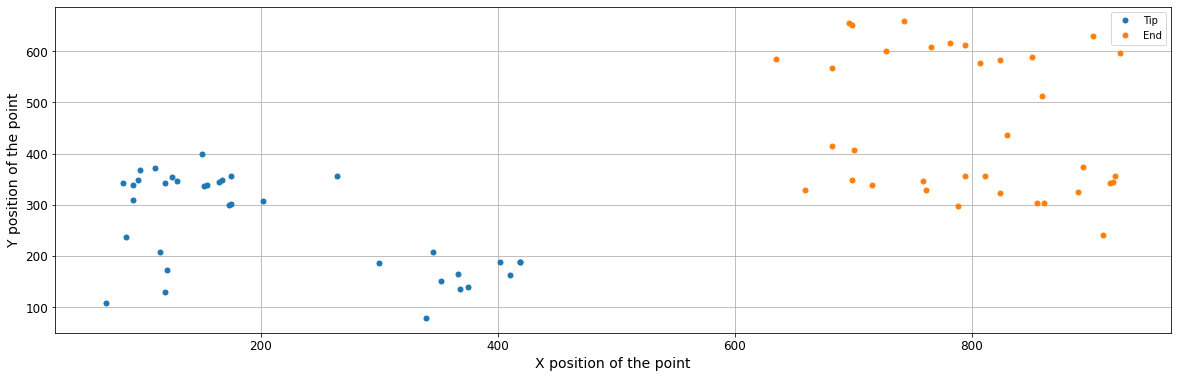

In [5]:
#Exploring the the distribution of the start and the end points of the data
plt.figure(figsize=(20,6))
plt.plot(annots[:,0],annots[:,1],'.',label='Tip',markersize=10)
plt.plot(annots[:,2],annots[:,3],'.',label='End',markersize=10)
plt.grid('on')
plt.xlabel('X position of the point')
plt.ylabel('Y position of the point')
plt.legend()


## Prepare the Data (10 points)
- Pre-process the data (e.g. down-sample, color channels)
- Extract features (if needed by chosen algorithms)


Use the cross validation for training and testing on the data by splitting it into subsets

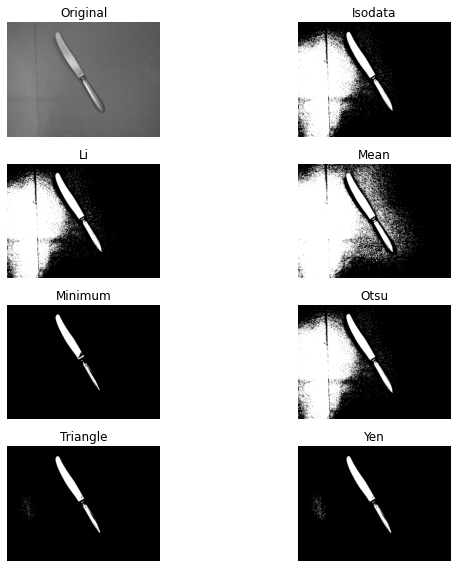

In [6]:
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import try_all_threshold


img_idx = 21
I = Is[img_idx]
grayscale_image = rgb2gray(I)

fig, ax = try_all_threshold(grayscale_image, figsize=(10, 8), verbose=False)
plt.show()


In [7]:
#For the patch creation extraction 
import skimage as sk

FEAT_SIZE = (9,9,3)

def patch_to_vec(P):
    x = sk.transform.resize(P,(9,9,3))
    return x

WIN_SIZE = (100, 100, 3)

# for convenience, half the window
HALF_WIN_SIZE = (WIN_SIZE[0] // 2, WIN_SIZE[1] // 2, WIN_SIZE[2])

def get_patch_at_point(I, p):
    p_x = int(p[0])
    p_y = int(p[1])
    P = I[p_y - HALF_WIN_SIZE[1]:p_y + HALF_WIN_SIZE[1],p_x - HALF_WIN_SIZE[0]:p_x + HALF_WIN_SIZE[0],:]
    return P

def sample_points_grid(I):
    # window centers
    W = np.shape(I)[1]
    H = np.shape(I)[0]
    
    step_size = (WIN_SIZE[0]//2, WIN_SIZE[1]//2)
    min_ys = range(0, H-WIN_SIZE[0]+1, step_size[0])
    min_xs = range(0, W-WIN_SIZE[1]+1, step_size[1])
    center_ys = range(HALF_WIN_SIZE[0], H-HALF_WIN_SIZE[0]+1, step_size[0])
    center_xs = range(HALF_WIN_SIZE[1], W-HALF_WIN_SIZE[1]+1, step_size[1])
    centers = np.array(np.meshgrid(center_xs, center_ys))
    centers = centers.reshape(2,-1).T
    centers = centers.astype(float) 
    
    # add a bit of random offset
    centers += np.random.rand(*centers.shape) * 10 
    
    # discard points close to border where we can't extract patches
    centers = remove_points_near_border(I, centers)
    
    return centers

def sample_points_around_pen(I, p1, p2):
    Nu = 100 # uniform samples (will mostly be background, and some non-background)
    Nt = 50 # samples at target locations, i.e. near start, end, and middle of pen
    
    target_std_dev = np.array(HALF_WIN_SIZE[:2])/3 # variance to add to locations

    upoints = sample_points_grid(I)
    idxs = np.random.choice(upoints.shape[0], Nu)
    upoints = upoints[idxs,:]
    
    
    # sample around target locations
    tpoints1 = np.random.randn(Nt,2)
    tpoints1 = tpoints1 * target_std_dev + p1

    tpoints2 = np.random.randn(Nt,2)
    tpoints2 = tpoints2 * target_std_dev + p2

    # sample over length pen
    alpha = np.random.rand(Nt)
    tpoints3 = p1[None,:] * alpha[:,None] + p2[None,:] * (1. - alpha[:,None])
    tpoints3 = tpoints3 + np.random.randn(Nt,2) * target_std_dev
    
    # merge all points
    points = np.vstack((upoints, tpoints1, tpoints2, tpoints3))
    
    # discard points close to border where we can't extract patches
    points = remove_points_near_border(I, points)
    
    return points

def remove_points_near_border(I, points):
    W = np.shape(I)[1]
    H = np.shape(I)[0]

    # discard points that are too close to border
    points = points[points[:,0] > HALF_WIN_SIZE[1],:]
    points = points[points[:,1] > HALF_WIN_SIZE[0],:]
    points = points[points[:,0] < W - HALF_WIN_SIZE[1],:]
    points = points[points[:,1] < H - HALF_WIN_SIZE[0],:]
    
    return points

CLASS_NAMES = [
    'background', # class 0
    'tip',        # class 1
    'end',        # class 2
    'middle'      # class 3
]

def make_labels_for_points(I, p1, p2, points):
    """ Determine the class label (as an integer) on point distance to different parts of the pen """
    num_points = points.shape[0]
    
    # for all points ....
    
    # ... determine their distance to tip of the pen
    dist1 = points - p1
    dist1 = np.sqrt(np.sum(dist1 * dist1, axis=1))
    
    # ... determine their distance to end of the pen
    dist2 = points - p2
    dist2 = np.sqrt(np.sum(dist2 * dist2, axis=1))

    # ... determine distance to pen middle
    alpha = np.linspace(0.2, 0.8, 100)
    midpoints = p1[None,:] * alpha[:,None] + p2[None,:] * (1. - alpha[:,None]) 
    dist3 = scipy.spatial.distance_matrix(midpoints, points)
    dist3 = np.min(dist3, axis=0)
    
    # the class label of a point will be determined by which distance is smallest
    #    and if that distance is at least below `dist_thresh`, otherwise it is background
    dist_thresh = WIN_SIZE[0] * 2./3.

    # store distance to closest point in each class in columns
    class_dist = np.zeros((num_points, 4))
    class_dist[:,0] = dist_thresh
    class_dist[:,1] = dist1
    class_dist[:,2] = dist2
    class_dist[:,3] = dist3
    
    # the class label is now the column with the lowest number
    labels = np.argmin(class_dist, axis=1)
    
    return labels

def count_classes(labels):
   
    zeros = 0
    ones = 0
    twos = 0
    threes = 0
    for i in range(len(labels)):
        if (labels[i] == 0):
            zeros = zeros + 1
        if (labels[i] == 1):
            ones = ones + 1
        if (labels[i] == 2):
            twos = twos + 1
        if (labels[i] == 3):
            threes = threes + 1
        
    count = np.array([zeros,ones,twos,threes])    
    return count

def extract_patches(I, p1, p2, strategy=None):
    
    # by default, if no strategy is explicitly defined, use strategy 2
    if strategy == 1:
        points = sample_points_grid(I)
    if strategy == 2 or strategy is None:
        points = sample_points_around_pen(I, p1, p2)
    
    # determine the labels of the points
    labels = make_labels_for_points(I, p1, p2, points)
    
    xs = []
    for p in points:
        P = get_patch_at_point(I, p)
        x = patch_to_vec(P)
        xs.append(x)
    X = np.array(xs)

    return X, labels, points

def extract_multiple_images(idxs, strategy=None):
    Xs = []
    ys = []
    points = []
    imgids = []

    for step, idx in enumerate(idxs):
        I = Is[idx]
        I_X, I_y, I_points = extract_patches(I, annots[idx,:2], annots[idx,2:], strategy=strategy)

        classcounts = count_classes(I_y)
        print(f'image {idx}, class count = {classcounts}')

        Xs.append(I_X)
        ys.append(I_y)
        points.append(I_points)
        imgids.append(np.ones(len(I_y),dtype=int)*idx)

    Xs = np.vstack(Xs)
    ys = np.hstack(ys)
    points = np.vstack(points)
    imgids = np.hstack(imgids)
    
    return Xs, ys, points, imgids

The training and the test set are not split randomly but sequentailly according to the index number so that the classifier never sees the the test data before the prediction when the code is run multiple times.

In [8]:
#spliting the images in the training and the test set
train_imgs = list(range(0,24))
test_imgs = list(range(24,len(Is)))
X_train, y_train, points_train, imgids_train = extract_multiple_images(train_imgs)
X_test, y_test, points_test, imgids_test = extract_multiple_images(test_imgs)

image 0, class count = [87 53 56 54]
image 1, class count = [84 57 60 49]
image 2, class count = [87 54 57 52]
image 3, class count = [88 55 57 50]
image 4, class count = [85 56 61 48]
image 5, class count = [89 56 57 48]
image 6, class count = [87 56 59 48]
image 7, class count = [87 53 60 50]
image 8, class count = [88 56 55 51]
image 9, class count = [85 57 55 53]
image 10, class count = [88 53 59 50]
image 11, class count = [89 58 59 44]
image 12, class count = [86 59 59 46]
image 13, class count = [87 53 53 57]
image 14, class count = [85 55 59 51]
image 15, class count = [86 54 55 55]
image 16, class count = [93 53 55 49]
image 17, class count = [89 65 57 39]
image 18, class count = [86 59 57 48]
image 19, class count = [90 59 57 44]
image 20, class count = [83 57 58 52]
image 21, class count = [84 53 57 55]
image 22, class count = [88 55 58 49]
image 23, class count = [88 60 61 41]
image 24, class count = [89 53 55 53]
image 25, class count = [87 57 60 46]
image 26, class count 

## Shortlist Promising Models (15 points)
- Compare at least 2 models. One of them needs to be a neural network, one of them needs to be not a neural network.
- Perform dimensionality reduction (if needed)
- Roughly tune those models
- Evaluate the models in terms of performance, bias, variance, etc.
- Pick one algorithm to develop further


In [9]:
# Creating neural networks in Keras 
# importing the related libraries
import glob# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import os, glob
import scipy

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import ipywidgets
from IPython.display import display

from collections import OrderedDict

import scipy
import skimage
import skimage.transform
import skimage.util

import tensorflow as tf
from tensorflow import keras

In [10]:
checkpoint_path = "learned_weights/weights.best.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 save_freq='epoch',
                                                 verbose=1)

In [19]:
#defining the config layer function
def config_layers(X_train, NNH_1, NNH_2, y_train):
    num_input_units = X_train.shape[1]
    NNH_1 = NNH_1
    NNH_2 = NNH_2
    num_logits = len(list(set(y_train)))
    return num_input_units, NNH_1, NNH_2, num_logits
def one_hot_encoding(y_orig):
    # YOUR CODE HERE
    y_orig = np.asarray(y_orig)
    y_one_hot = np.zeros((y_orig.shape[0], y_orig.max()+1))
    y_one_hot[np.arange(y_orig.shape[0]),-y_orig-1] = 1
    y_one_hot = y_one_hot.astype(np.uint8)
    return y_one_hot
def our_predict(model, X):
    # YOUR CODE HERE
    y_predict_raw = model.predict(X)
    y_predict = np.argmax(y_predict_raw,axis=1)
    #raise NotImplementedError()
    return y_predict, y_predict_raw
def plot_image_classification_results(img_idx, y_pred_raw, points, imgids, Is):
    mask = imgids == img_idx
    points = points[mask,:]
    predictions = y_pred_raw[mask,:]
    y_pred = np.argmax(predictions, axis = 1)
    best_idx1 = predictions[:,1].argmax()
    best_idx2 = predictions[:,2].argmax()
    
    # load image
    I = Is[img_idx]

    plt.figure()
    plt.imshow(I)
    plt.plot(points[y_pred==0, 0], points[y_pred==0, 1], '.r')
    plt.plot(points[y_pred==3, 0], points[y_pred==3, 1], '.y')
    plt.plot(points[y_pred==1, 0], points[y_pred==1, 1], '.g')
    plt.plot(points[y_pred==2, 0], points[y_pred==2, 1], '.b')
    plt.plot(points[(best_idx1, best_idx2), 0], points[(best_idx1, best_idx2), 1], 'c-', linewidth=2)
    plt.plot(points[best_idx1, 0], points[best_idx1, 1], 'co')
    plt.show()
    
def plot_nth_train_result(n):
    plot_image_classification_results(test_img_idxs[n], y_predict_raw, points_test, imgids_test, Is)

In [20]:
from tensorflow.python.keras.layers import Dense

# defining the keras model

num_input_units, NNH_1, NNH_2, num_logits = config_layers(X_train, 173, 67, y_train)
X_train = np.reshape(X_train,(len(X_train),243))
X_test = np.reshape(X_test,(len(X_test),243))
image_model = keras.models.Sequential()
image_model.add(Dense(NNH_1, input_dim=num_input_units, activation='relu'))
image_model.add(Dense(NNH_2, input_dim=num_input_units, activation='relu'))
image_model.add(Dense(num_logits, activation='softmax'))


In [24]:
# compiling the keras model
from tensorflow.keras import metrics
optimizer = keras.optimizers.Adam(lr=0.01)
image_model.compile(optimizer=optimizer , loss='binary_crossentropy' , metrics=['accuracy'])
y_train_one_hot = one_hot_encoding(y_train)

In [25]:
#fitting the keras model
validation_split = 0.33
epochs = 30
batch_size = 10
y_train_one_hot = one_hot_encoding(y_train)
history = image_model.fit(X_train, y_train_one_hot, validation_split=validation_split,\
                    epochs=epochs, batch_size=batch_size, callbacks = [cp_callback])

Epoch 1/30
360/402 [=========================>....] - ETA: 0s - loss: 0.3248 - accuracy: 0.7642
Epoch 00001: val_accuracy did not improve from 0.90960
402/402 [==============================] - 1s 2ms/step - loss: 0.3139 - accuracy: 0.7711 - val_loss: 0.2832 - val_accuracy: 0.7843
Epoch 2/30
353/402 [=========================>....] - ETA: 0s - loss: 0.1797 - accuracy: 0.8571
Epoch 00002: val_accuracy did not improve from 0.90960
402/402 [==============================] - 0s 933us/step - loss: 0.1788 - accuracy: 0.8583 - val_loss: 0.2094 - val_accuracy: 0.8525
Epoch 3/30
345/402 [========================>.....] - ETA: 0s - loss: 0.1376 - accuracy: 0.9011
Epoch 00003: val_accuracy did not improve from 0.90960
402/402 [==============================] - 0s 907us/step - loss: 0.1372 - accuracy: 0.9012 - val_loss: 0.2393 - val_accuracy: 0.8364
Epoch 4/30
345/402 [========================>.....] - ETA: 0s - loss: 0.1354 - accuracy: 0.9003
Epoch 00004: val_accuracy did not improve from 0.90960

372/402 [==========================>...] - ETA: 0s - loss: 0.1015 - accuracy: 0.9324
Epoch 00028: val_accuracy did not improve from 0.91768
402/402 [==============================] - 0s 887us/step - loss: 0.1013 - accuracy: 0.9326 - val_loss: 0.1694 - val_accuracy: 0.8909
Epoch 29/30
346/402 [========================>.....] - ETA: 0s - loss: 0.0828 - accuracy: 0.9410
Epoch 00029: val_accuracy did not improve from 0.91768
402/402 [==============================] - 0s 944us/step - loss: 0.0826 - accuracy: 0.9416 - val_loss: 0.1648 - val_accuracy: 0.9157
Epoch 30/30
340/402 [========================>.....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9487
Epoch 00030: val_accuracy did not improve from 0.91768
402/402 [==============================] - 0s 954us/step - loss: 0.0768 - accuracy: 0.9480 - val_loss: 0.1899 - val_accuracy: 0.8889


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


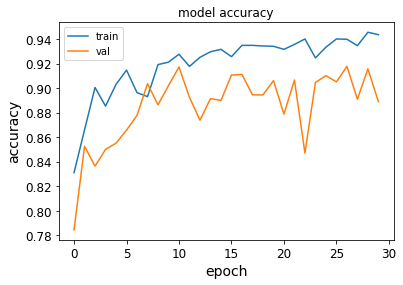

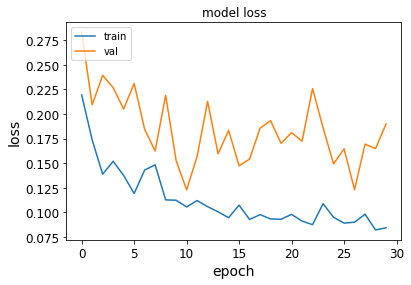

86/86 [==============================] - 0s 2ms/step - loss: 0.2494 - accuracy: 0.8496
Accuracy: 84.96


interactive(children=(IntSlider(value=5, description='n', max=10), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_nth_train_result(n)>

In [26]:
#plotting the training log
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#calculating the accuracy of the predictions
y_test_one_hot = one_hot_encoding(y_test)
_, accuracy = image_model.evaluate(X_test, y_test_one_hot)
print('Accuracy: %.2f' % (accuracy*100))

y_predict_train, _ = our_predict(image_model, X_train)

test_img_idxs = np.unique(imgids_test)
y_predict, y_predict_raw = our_predict(image_model, X_test)
ipywidgets.interact(plot_nth_train_result, n=(0,len(test_img_idxs)-1))

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

sgd_clf = SGDClassifier(loss="log" , max_iter=1000, tol=1e-3, random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42) # this should be the Decision Tree classifer
rf_clf = RandomForestClassifier(random_state=42)

X_train = np.reshape(X_train,(len(X_train),243))
X_test = np.reshape(X_test,(len(X_test),243))
sgd_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

y_train_pred_sgd = sgd_clf.predict(X_train)
y_train_pred_dt = dt_clf.predict(X_train)
y_train_pred_rf = rf_clf.predict(X_train)

print("SGD training accuracy score = ",accuracy_score(y_train, y_train_pred_sgd),"\n")
print("DT training accuracy score = ",accuracy_score(y_train, y_train_pred_dt),"\n")
print("RF training accuracy score = ",accuracy_score(y_train, y_train_pred_rf),"\n")

#now testing on the test data
y_test_pred_sgd = sgd_clf.predict(X_test)
y_test_pred_dt = dt_clf.predict(X_test)
y_test_pred_rf = rf_clf.predict(X_test)

print("SGD test accuracy score = ",accuracy_score(y_test, y_test_pred_sgd),"\n")
print("DT test accuracy score = ",accuracy_score(y_test, y_test_pred_dt),"\n")
print("RF test accuracy score = ",accuracy_score(y_test, y_test_pred_rf),"\n")



SGD training accuracy score =  0.8819409704852427 

DT training accuracy score =  1.0 

RF training accuracy score =  1.0 

SGD test accuracy score =  0.7633114514952589 

DT test accuracy score =  0.6323851203501094 

RF test accuracy score =  0.6356673960612691 



## Fine-Tune the System (15 points)
- Perform hyperparameter optimization (including pre-processing steps)
- Evaluate the final model (similar to “Shortlist Promising Models” above)
- Evaluate if your dataset was large and rich enough
- Save the parameters of your best model to your harddrive (use pickle for sklearn or built-in save/load for keras), you will need to be able to reload your model without training in the next step. Be sure to include the saved parameters in your zip file so we can evaluate your best model too even without rerunning the notebook up to here.


Use the grid search method to optimize the hyperparameter of any classifier


## Present Your Solution (10 points)
- Summarize your main decisions and insights
- Create a stand-alone demo. I.e., a block of cells that can be run on its own. For that you will need to load your pre-trained best model you saved in the previous section, measure its performance on the test set, present results both in numbers and with illustrative examples


## Further Develop Your System (Bonus, max 10 points)
- With this part you can make up for lost points in the main part. The maximum grade is still a 10. 
- Extend the system to work with either multiple types of cutlery, or multiple objects in a camera image, or different tables, or distractor objects, or different brands of your chosen type of cutlery, or a combination thereof.
